<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbers from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

# Setup:

In [1]:
# Import libraries:

# Data:
import pandas as pd
import numpy as np

import re

# Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# NLP:
import spacy
from collections import Counter

# Model: Pre-trained SpaCy NLP model for English:
model_nlp = spacy.load("en_core_web_lg")

# Import Data:

In [2]:
# Import Yelp coffee shops reviews dataset from GitHub

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

yelp_data = pd.read_csv(url)

# Data Prep.:

In [3]:
# Convert the star ratings into numbers (floats):

# Function to pull the numeric star rating from the 'star_rating' strings:
def get_rating_num(text):
    rating = float(re.search(r"\d\.\d", text).group())
    return rating

# Convert the star_rating column values to their respective numerical star ratings as floats:
yelp_data['star_rating'] = yelp_data['star_rating'].apply(lambda x: get_rating_num(x))

In [4]:
# Function that returns the review date from a raw Yelp review string:
def get_review_date(review):
    """
    Function that returns the review date from a raw Yelp review string.
    """
    date = re.search(r"\d*/\d*/\d\d\d\d", review).group()
    date = pd.to_datetime(date)
    return date

In [5]:
# Function that returns the customer's # of check-ins to a coffee shop from a Yelp review:
def get_check_ins(review):
    """
    Function that returns the customer's # of check-ins to a coffee shop from a Yelp review.
    """
    check_ins_search = re.search(r"\d check-in*", review)
    if check_ins_search:
        num_check_ins = check_ins_search.group()[:1]
    else:
        num_check_ins = 0
    return num_check_ins

In [6]:
# Function that removes extra info from the raw text version of a Yelp review, and returns the cleaned-up review.
def clean_up_review(review):
    """
    Function that removes extra info from the raw text version of a Yelp review, and returns the cleaned-up review.
    """
    
    # Remove the review date, if any, from the review string:
    review = re.sub(r" \d*/\d*/\d\d\d\d ", "", review)
    
    # Remove the # check-ins, if any, from the review string:
    review = re.sub(r"\d check-i[a-z]* ", "", review)
    
    return review

In [7]:
# 'review_date': Get review dates from the reviews, and add them to separate columns for date, year, month and day:
yelp_data['review_date'] = yelp_data['full_review_text'].apply(lambda x: get_review_date(x))
yelp_data['year'] = yelp_data['review_date'].dt.year
yelp_data['month'] = yelp_data['review_date'].dt.month
yelp_data['day'] = yelp_data['review_date'].dt.day

# 'check_ins': Get the customers' # of check-ins to that coffee shop from the raw reviews, and add them to new column 'check_ins':
yelp_data['check_ins'] = yelp_data['full_review_text'].apply(lambda x: get_check_ins(x))

# 'review': Get cleaned-up text reviews from the raw review text, and add them to a new column named 'review':
yelp_data['review'] = yelp_data['full_review_text'].apply(lambda x: clean_up_review(x))

# 'rating_category': Is the average star rating of the coffee shop good (4-5) or bad (1-3)?
def get_rating_category(star_rating):
    if star_rating >= 4.0:
        rating_category = 'good'
    elif star_rating < 4.0:
        rating_category = 'bad'
    else:
        rating_category = np.NaN
    return rating_category
yelp_data['rating_category'] = yelp_data['star_rating'].apply(lambda x: get_rating_category(x))

### Lemmatized Tokens, Without Stop Words:

In [8]:
# Our list of stop words:
domain_specific_stop_words = ['Yelp', 
                              'review', 
                              'reviews', 
                              'coffee', 
                              'tea', 
                              'place', 
                              'order', 
                              'shop', 
                              'time', 
                              'austin', 
                              'food', 
                              'drink'
                             ]
STOP_WORDS = model_nlp.Defaults.stop_words.union(domain_specific_stop_words)

In [9]:
# Tokenize the Yelp reviews --> add tokens to dataframe as a separate column:

# Initialize the tokenizer:
tokenizer = spacy.tokenizer.Tokenizer(model_nlp.vocab)

# Tokenize the reviews:
tokens = []
for review in tokenizer.pipe(yelp_data['review']):
    
    review_tokens = []
    for token in review:
        if (token.text.lower() not in STOP_WORDS) and (token.is_stop == False) and (token.is_punct == False) and (token.is_space == False):
            review_tokens.append(token.text.lower())
    
    tokens.append(review_tokens)

# Add tokenized reviews to dataframe as new column, 'tokens':
yelp_data['tokens'] = tokens

In [10]:
# Function that lemmatizes a Yelp review, returning the list of lemmatized tokens:
def get_lemmas(text):
    """
    Function that lemmatizes a Yelp review, returning the list of lemmatized tokens.
    """

    # [?? ??] 
    review = model_nlp(text)

    # Make a list with lemmatized tokens in the review, and return it:
    review_tokens = []
    
    for token in review:
        if (token.text.lower() not in STOP_WORDS) and (token.is_stop == False) and (token.is_punct == False) and (token.is_space == False):
            review_tokens.append(token.lemma_.lower())
    
    return review_tokens

In [11]:
# Lemmatize each Yelp review, and add the list of lemmatized tokens for each to the dataframe as new column, 'lemmas':
yelp_data['lemmas'] = yelp_data['review'].apply(get_lemmas)

In [12]:
# Create separate datasets with reviews for:
# - All: Reviews for all coffee shops
# - Good only: Reviews for coffee shops with "good" (4 or 5) average reviews only
# - Bad only: Reviews for coffee shops with "bad" (1-3) average reviews only
reviews_all = yelp_data
reviews_good = yelp_data[yelp_data['rating_category'] == 'good']
reviews_bad = yelp_data[yelp_data['rating_category'] == 'bad']

# Analysis: 
## What Words are Most Commonly Used to Describe Good vs. Bad Coffee Shops?

In [13]:
# Function that takes a corpusyelp_data text documents (e.g., a Pandas series or df column of strings), and 
# returns a dataframe with the word counts and frequency of appearance of our tokenized words:
def get_word_counts(corpus):
    """
    Function that takes a corpus of text documents (e.g., a Pandas series or df column of strings), and 
    returns a dataframe with the word counts and frequency of appearance of our tokenized words:
    """

    # Instantiate the counters we need:
    word_counts = Counter()
    appears_in = Counter()

    # Add words from corpus to our counters:
    # (Note: the update() method is different for Counters vs. dicts: for Counters, Counter.update(text_doc) adds text_doc to the counter)
    for review in corpus:
        word_counts.update(review)
        appears_in.update(set(review))

    # Make new dataframe for word counts data for the entire corpus:
    word_counts_df = pd.DataFrame(data=word_counts.items(), columns=['word', 'count'])

    # Add other relevant data:

    # 'rank': rank of that word by word count:
    word_counts_df['rank'] = word_counts_df['count'].rank(method='first', ascending=False)

    # 'count_pct_total': That word's count as a % of total word count (all words):
    total_word_count = word_counts_df['count'].sum()
    word_counts_df['count_pct_total'] = word_counts_df['count'].apply(lambda x: x / total_word_count)

    # 'count_pct_total_cumulative': Cumulative total % of total word count (all words) accounted for by words up to that point (rank):
    word_counts_df = word_counts_df.sort_values(by='rank', ascending=True)
    word_counts_df['count_pct_total_cumulative'] = word_counts_df['count_pct_total'].cumsum()

    # 'reviews_appears_in': # of reviews that word appears in:
    appears_in_df = pd.DataFrame(data=appears_in.items(), columns=['word', 'reviews_appears_in'])
    word_counts_df = word_counts_df.merge(appears_in_df, how='left', on='word')

    # 'reviews_appears_in_pct': % of all reviews that word appears in:
    total_reviews = len(corpus)
    word_counts_df['reviews_appears_in_pct'] = word_counts_df['reviews_appears_in'].apply(lambda x: x / total_reviews)

    return word_counts_df.sort_values(by='rank')

In [14]:
# Get a dataframe with word counts data for our tokenized+lemmatized text data, 
# using our above-defined get_word_counts() function:
word_counts_all = get_word_counts(reviews_all['lemmas'])
word_counts_good = get_word_counts(reviews_good['lemmas'])
word_counts_bad = get_word_counts(reviews_bad['lemmas'])

In [15]:
word_counts_all.head(10)

,word,count,rank,count_pct_total,count_pct_total_cumulative,reviews_appears_in,reviews_appears_in_pct
0,good,5418,1.0,0.016572,0.016572,3604,0.473214
1,great,3952,2.0,0.012088,0.028660,2857,0.375131
2,like,3379,3.0,0.010335,0.038995,2273,0.298451
3,come,2640,4.0,0.008075,0.047070,1934,0.253939
4,love,2379,5.0,0.007277,0.054347,1818,0.238708
5,try,2144,6.0,0.006558,0.060905,1673,0.219669
6,work,1925,7.0,0.005888,0.066793,1492,0.195903
7,get,1922,8.0,0.005879,0.072671,1485,0.194984
8,latte,1879,9.0,0.005747,0.078419,1264,0.165966
9,nice,1804,10.0,0.005518,0.083937,1508,0.198004


In [16]:
word_counts_good.head(10)

,word,count,rank,count_pct_total,count_pct_total_cumulative,reviews_appears_in,reviews_appears_in_pct
0,good,4418,1.0,0.017341,0.017341,2958,0.481759
1,great,3480,2.0,0.013659,0.031001,2509,0.408632
2,like,2434,3.0,0.009554,0.040555,1677,0.273127
3,love,2126,4.0,0.008345,0.048899,1609,0.262052
4,come,1989,5.0,0.007807,0.056706,1482,0.241368
5,try,1712,6.0,0.006720,0.063426,1331,0.216775
6,latte,1551,7.0,0.006088,0.069514,1035,0.168567
7,friendly,1523,8.0,0.005978,0.075492,1446,0.235505
8,work,1517,9.0,0.005954,0.081447,1188,0.193485
9,get,1473,10.0,0.005782,0.087228,1149,0.187134


In [17]:
word_counts_bad.head(10)

,word,count,rank,count_pct_total,count_pct_total_cumulative,reviews_appears_in,reviews_appears_in_pct
0,good,1000,1.0,0.013856,0.013856,646,0.437669
1,like,945,2.0,0.013094,0.026951,596,0.403794
2,come,651,3.0,0.009020,0.035971,452,0.306233
3,great,472,4.0,0.006540,0.042511,348,0.235772
4,service,450,5.0,0.006235,0.048747,347,0.235095
5,go,450,6.0,0.006235,0.054982,338,0.228997
6,get,449,7.0,0.006222,0.061204,336,0.227642
7,try,432,8.0,0.005986,0.067190,342,0.231707
8,order,425,9.0,0.005889,0.073078,308,0.208672
9,work,408,10.0,0.005653,0.078732,304,0.205962


In [18]:
# Function that plots and displays a CDF of our input word counts:
def show_word_count_cdf(word_counts, reviews_category: str, cdf_threshold=0.75):
    """
    Function that plots and displays a CDF of our input word counts.
    cdf_threshold: Function will show how many unique words account for cdf_threshold (%) of total word count.
    """
    
    ax = sns.lineplot(x='rank', y='count_pct_total_cumulative', data=word_counts)

    # Figure out and display how many words account for 
    # cdf_threshold of our total word count (total words used in reviews):
    plt.axhline(y=cdf_threshold, linestyle='--', color='lightsteelblue')
    words_to_threshold = word_counts[word_counts['count_pct_total_cumulative'] <= cdf_threshold].iloc[-1]['rank']
    plt.axvline(x=words_to_threshold, linestyle='--', color='lightsteelblue')
    cdf_text = str(f"{cdf_threshold * 100:.0f}% of total word count from: {words_to_threshold:.0f} words")
    ax.text(s=cdf_text, x=words_to_threshold * 1.30, y=cdf_threshold * 0.85, horizontalalignment='left')

    title = str(f"{reviews_category.capitalize()} Coffee Shops' Reviews: \n{cdf_text}")
    plt.title(title, fontweight='bold', fontsize=14)
    plt.xlabel('# of unique words')
    plt.ylabel('% of total words used in all reviews')
    plt.show()

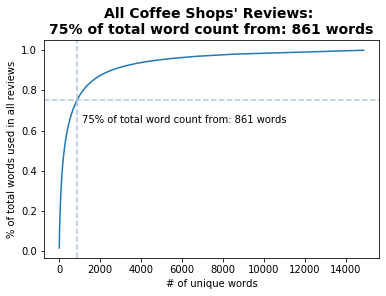

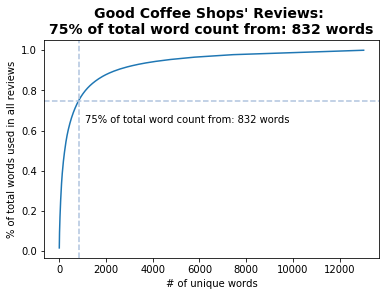

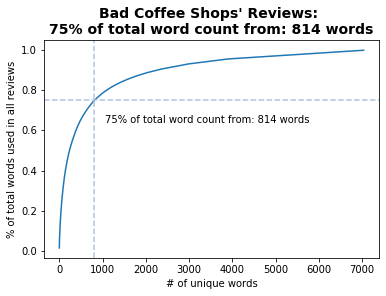

In [19]:
# Plot CDFs of words used in reviews for all vs. good vs. bad coffee shops:
show_word_count_cdf(word_counts_all, reviews_category='All')
show_word_count_cdf(word_counts_good, reviews_category='Good')
show_word_count_cdf(word_counts_bad, reviews_category='Bad')

# Visualization: Most-used Words Describing Coffee Shops with Good vs. Bad Reviews:

In [20]:
# Function that displays a tree map showing top 20 words used in the input corpus of reviews, 
# and their frequencies of use (% of total word count):
def display_word_count_map(word_counts, reviews_category: str):
    """
    Function that displays a tree map showing top 20 words used in the input corpus of reviews, 
    and their frequencies of use (% of total word count).
    """
    import squarify

    word_counts_top20 = word_counts[word_counts['rank'] <= 20]

    squarify.plot(sizes=word_counts_top20['count_pct_total'], label=word_counts_top20['word'], alpha=0.8)
    
    title = str(f"{reviews_category.capitalize()} Coffee Shops' Reviews: Most-used Words")
    plt.title(title, y=1.01, fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.show()

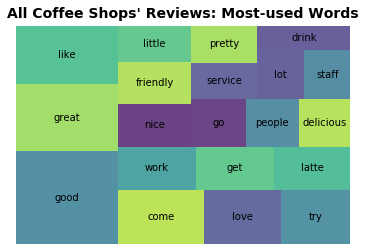

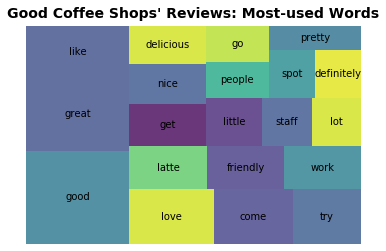

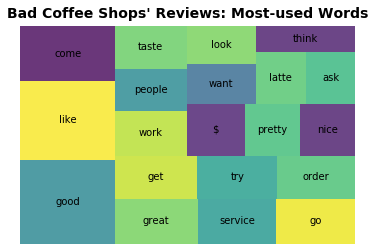

In [21]:
# Plot tree maps showing the most-used words in reviews for all vs. good vs. bad coffee shops:
display_word_count_map(word_counts_all, reviews_category='All')
display_word_count_map(word_counts_good, reviews_category='Good')
display_word_count_map(word_counts_bad, reviews_category='Bad')

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

